# Analyzing Segmentador data
Gabriel Emilio Herrera Oropeza <br>
13/06/2022

## *INSTRUCTIONS TO DEVELOPERS*

**Make sure to fetch and pull the most updated code and run `pip install .` before using the jupyter notebooks. Codes are constantly being improved and the workflow below work best with the newest version.**

This document describes the workflow to analyze data from segmented images that were previously processed by `insert tool name`. We will show how to import, visualise, filter and cluster the data using robust, simple-to-use functions. Many of these functions take up positional arguments that can be modified. To display the usage of these functions, run `help(name_of_function)`.

We begin by importing the `tool name` module.

In [70]:
from ngtools.analyzer import Analyzor

## Create Analyzor object class

We provide an Analyzor object class that facilitates storage of nuclei segmented data and its downstream processing. To construct this object, we can easily pass the path to Segmentador output directory to `Analyzor` class function:

In [71]:
path_to_experiments = "/Users/m./Desktop/Somya/Day14_INs"
obj = Analyzor(path_to_experiments)

### Preview data

You may extract information from the Analyzor object in many ways. Below are some useful functions:

In [72]:
# print out number of cells
obj.ncells()

# print out features from Segmentador
obj.features()

# preview data
obj.showData()
obj.showData(vars = ["cellID", "avg_intensity_dapi"])

4380
      cellID  avg_intensity_dapi  nuclear_area  nuclear_perimeter  major_axis  \
0          1                 787            34                 28        12.7   
1          2                 977           101                 39        14.5   
2          3                 856           254                 66        26.6   
3          4                 374            58                 30         9.7   
4          5                1010           124                 43        14.7   
...      ...                 ...           ...                ...         ...   
4375     150                 673           130                 43        14.9   
4376     151                1115            77                 34        12.4   
4377     152                1089            91                 37        13.0   
4378     153                1945            39                 23         8.2   
4379     154                 765            37                 27        11.5   

      minor_axis  axes

### Plot data

Data from Analyzor object can be visualised using scatterplot, violinplot or lineplot. For example, to plot a scatterplot of `nuclear_area` against `avg_intensity_dapi`, you can run:

In [73]:
obj.showADataVars()

['avg_intensity_dapi', 'nuclear_area', 'nuclear_perimeter', 'major_axis', 'minor_axis', 'axes_ratio', 'circularity', 'eccentricity', 'solidity', 'avg_intensity_core_dapi', 'avg_intensity_internal_ring_dapi', 'avg_intensity_external_ring_dapi', 'total_intensity_core_dapi', 'total_intensity_internal_ring_dapi', 'total_intensity_external_ring_dapi', 'total_intensity_dapi', 'avg_intensity_beta3', 'total_intensity_beta3', 'avg_intensity_rfp', 'total_intensity_rfp', 'avg_intensity_laminB1', 'total_intensity_laminB1', 'beta3_x_rfp', 'beta3_x_laminB1', 'rfp_x_laminB1', 'beta3_x_rfp_x_laminB1', 'dna_peaks', 'dna_dots', 'dna_dots_size_median', 'spatial_entropy', 'iNs']


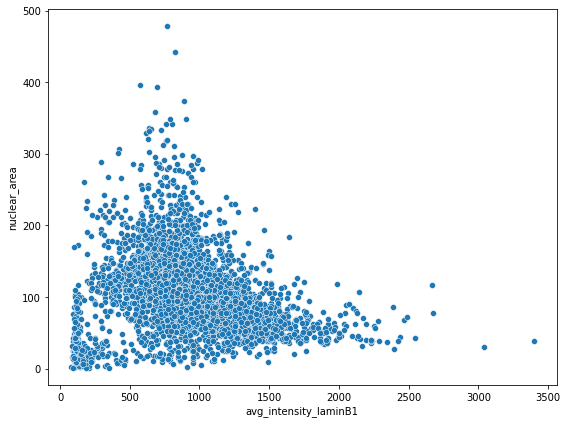

In [74]:
obj.plotData(x = "avg_intensity_laminB1", y = "nuclear_area",
            plot_type = "scatter", hue = None)

You may color cells by any categorical variable in your data by providing a feature name to the `hue` parameter. The x- and y-axis can be transformed and the order of the cells can be shuffled. Run `help(obj.plotData)` for a guide.

### Show cell images

The Analyzor object holds the path to the image of each cells and has the ability to display this image.
Simply run the `showCell` function:


Enter number of nuclei to show (any integer OR "all"): 5

Showing 5 cells of a total of 4380 in the selected data
Input channel for red [dapi/rfp/beta3/laminB1/None] None
Input channel for green [dapi/rfp/beta3/laminB1/None] beta3
Input channel for blue [dapi/rfp/beta3/laminB1/None] None


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 58.73it/s]


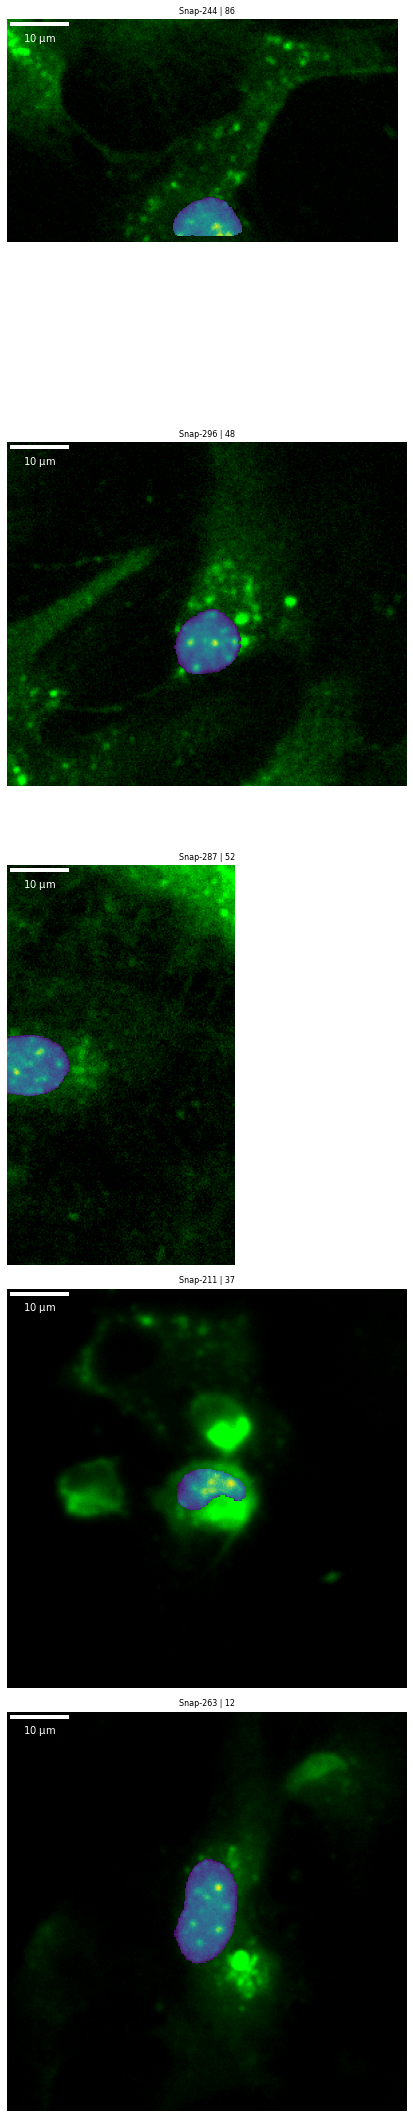

In [75]:
obj.showCells()

Running the above function without any input parameters will invoke an interactive prompt. Alternatiely, you may provide the number of cells and channels to display as such:


Showing 5 cells of a total of 4380 in the selected data


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 56.14it/s]


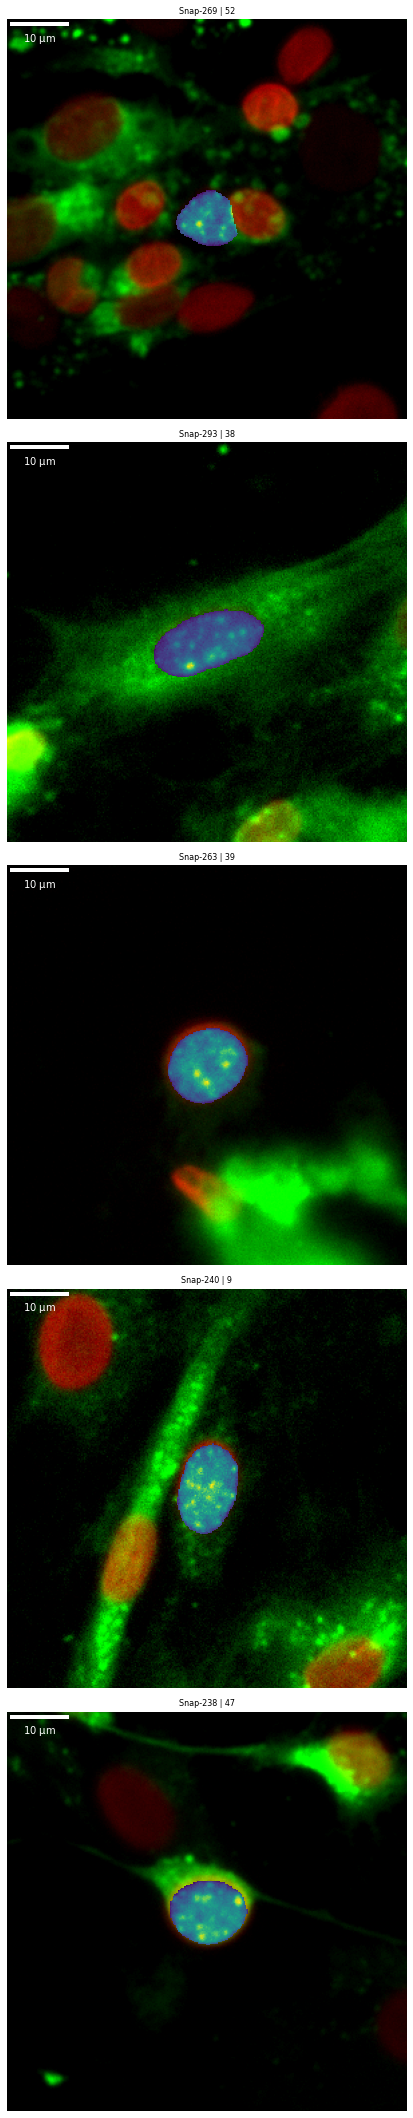

In [13]:
obj.showCells(n=5, ch2show = {'red': "rfp", 'green': "beta3"})

To maximise the use of RGB channels, `showCell` will show the DAPI/nucleus as a separate layer by default. This can be switched off using the `show_nucleus` flag:


Showing 5 cells of a total of 4380 in the selected data


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 53.87it/s]


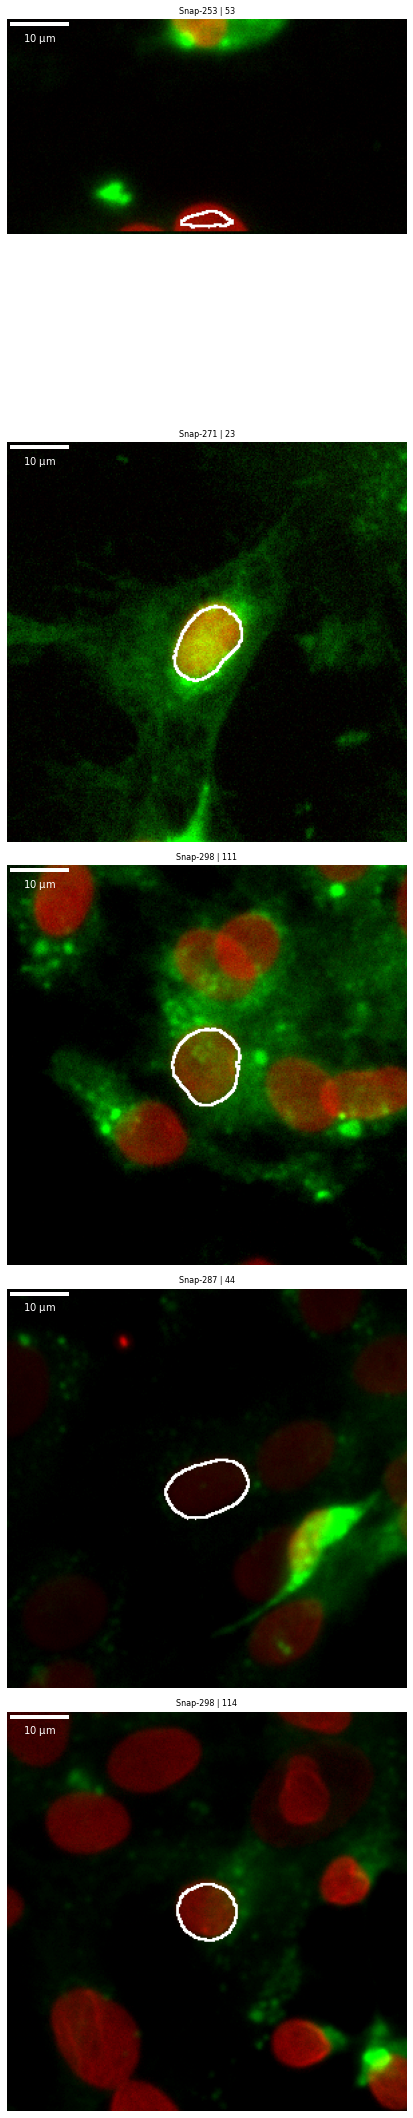

In [14]:
obj.showCells(n=5, ch2show = {'red': "rfp", 'green': "beta3"}, show_nucleus = False)

## Data preprocessing

### Center DAPI intensity

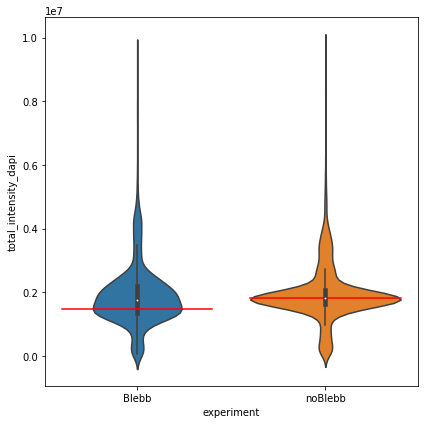

In [76]:
obj.ctrDAPI()

### Identify Single Cells
Identify single cells based on DNA marker content. (Here we have to give the option to select the range of the spread we want to have from sum of DAPI intensity. You can see blebb and no Blebb have different spreading.

In [77]:
obj.findSingleCells()

100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 143.26it/s]


### Normalize channel intensities. We should see how it looks like as in DAPI intensity.

In [78]:
obj.normIntensity(method = "mode", nbins = 100)

100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 73.72it/s]


**TO DO**: Order_by feature

### Filter cells

In [84]:
# Keep only single cells
obj.filterCells(expr = "isSingleCell == True")

ValueError: Found array with 0 sample(s) (shape=(0, 31)) while a minimum of 1 is required by StandardScaler.

In [85]:
%matplotlib tk
chosen_cells = obj.chooseCells("rfp_group", "beta3_group")

In [82]:
%matplotlib inline

In [83]:
obj.filterCells(cells = chosen_cells)

ValueError: Found array with 0 sample(s) (shape=(0, 31)) while a minimum of 1 is required by StandardScaler.

In [58]:
obj.count(["rfp_group","beta3_group"])

rfp_group  beta3_group
2          2              884
1          2              352
3          3              278
2          3              207
3          2              162
           4               53
4          4               34
           3               29
2          4               17
4          2                7
1          3                6
4          5                4
3          5                3
1          4                2
2          5                1
5          4                1
dtype: int64


## Dimensional reduction and clustering

### Prepare matrix

In [66]:
obj.showADataVars()


['avg_intensity_dapi', 'nuclear_area', 'nuclear_perimeter', 'major_axis', 'minor_axis', 'axes_ratio', 'circularity', 'eccentricity', 'solidity', 'avg_intensity_core_dapi', 'avg_intensity_internal_ring_dapi', 'avg_intensity_external_ring_dapi', 'total_intensity_core_dapi', 'total_intensity_internal_ring_dapi', 'total_intensity_external_ring_dapi', 'total_intensity_dapi', 'avg_intensity_beta3', 'total_intensity_beta3', 'avg_intensity_rfp', 'total_intensity_rfp', 'avg_intensity_laminB1', 'total_intensity_laminB1', 'beta3_x_rfp', 'beta3_x_laminB1', 'rfp_x_laminB1', 'beta3_x_rfp_x_laminB1', 'dna_peaks', 'dna_dots', 'dna_dots_size_median', 'spatial_entropy', 'iNs']


In [68]:
exclude_feat = ['total_intensity_core_dapi', 'total_intensity_internal_ring_dapi', 'total_intensity_external_ring_dapi', 'total_intensity_dapi',
               'total_intensity_beta3', 'total_intensity_rfp', 'total_intensity_laminB1', 'beta3_x_laminB1', 'rfp_x_laminB1', 'beta3_x_rfp_x_laminB1']
obj.excludeVars(vars = exclude_feat)
obj.showADataVars()

KeyError: "['beta3_x_rfp_x_ngn', 'total_intensity_ngn', 'beta3_x_ngn', 'rfp_x_ngn'] not found in axis"

In [ ]:
## This graphic should be before

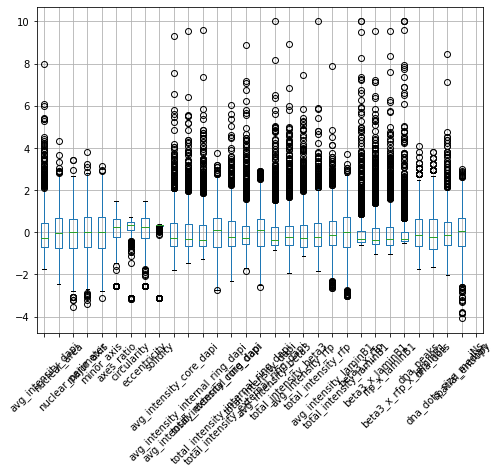

In [64]:
obj.plotVarDist(vars = "all", data_type="scaled")

### Cluster and dim reduction

In [65]:
obj.findNeighbours(method = "umap")
obj.findClusters(method = "leiden", res=0.6)
obj.runDimReduc(method = "umap")

computing neighbors


ValueError: Input contains NaN.

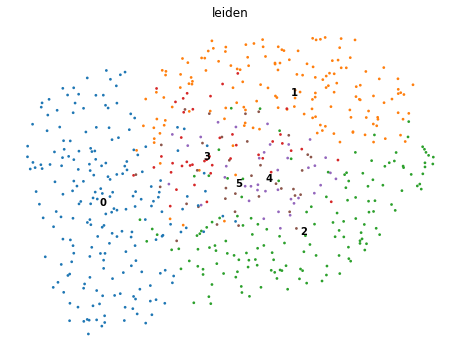

In [27]:
# Plot UMAP showing features
obj.plotDim(hue = "leiden", method="umap")

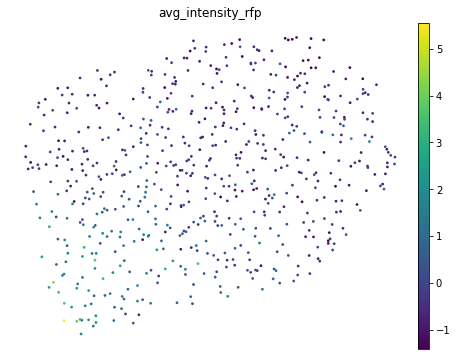

In [28]:
obj.plotDim(hue = "avg_intensity_rfp", method="umap")

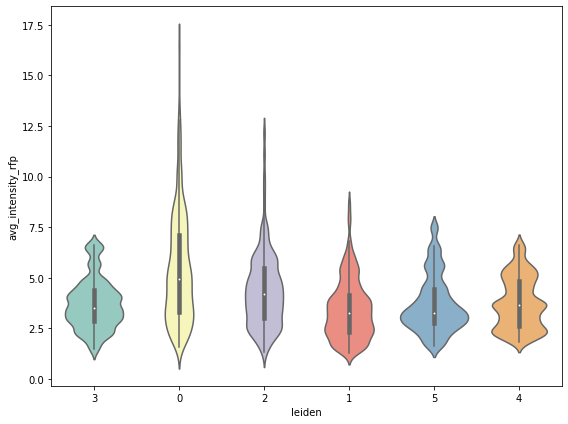

In [29]:
obj.plotData(x="leiden", y = "avg_intensity_rfp", plot_type = "violin")

In [31]:
obj.showCell(RGB_contrasts=[4,3,4], n=5, ch2show={'red':'rfp', 'green':'beta3'}, filter = "leiden == '0'")

AttributeError: 'Analyzor' object has no attribute 'showCell'

#### DIFFMAP

In [32]:
obj.findNeighbours(method = "gauss")
obj.findClusters(method = "leiden")
obj.runDimReduc(method = "diffmap")

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Leiden clustering
    finished: found 3 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         0.8865982  0.8280712  0.7638971  0.7191061  0.6835713
     0.6543614  0.6399888  0.6124589  0.59262794 0.56789017 0.55957013
     0.55490464 0.532937   0.49777788]
    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns) (0:00:00)


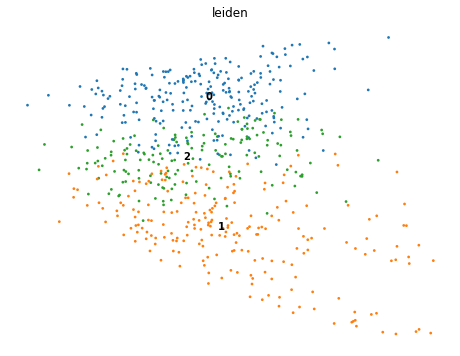

In [33]:
obj.plotDim(hue = "leiden", method="diffmap")

#### Pseudotime
Choose a root cell for diffusion pseudotime:

In [ ]:
%matplotlib tk
root_cells = obj.chooseCells(reduction = "diffmap")

In [ ]:
%matplotlib inline

In [ ]:
obj.runPT(root_cells = root_cells)

In [ ]:
obj.plotDim(hue = "dpt_pseudotime", method="diffmap")

#### Stacked violin plot

In [ ]:
fig, ax = plt.subplots(figsize = (5, 7))
sc.pl.stacked_violin(adata, data_cols, groupby = 'experiment', swap_axes = True, ax = ax, dendrogram = True)
fig.tight_layout()
plt.show()

#### Pseudotime - heatmap

In [ ]:
# Enter order of clusters in pseudotime
pseudotime_path = [3,4,7]

In [ ]:
# Heatmap - pseudotime
sc.pl.paga_path(
    adata, 
    pseudotime_path, 
    data_cols,
    show_node_names = True,
    n_avg = 50,
    annotations = ['dpt_pseudotime'],
    show_colorbar = True,
    color_map = 'coolwarm',
    groups_key = 'leiden',
    color_maps_annotations = {'dpt_pseudotime': 'viridis'},
    title = 'Path',
    return_data = False,
    normalize_to_zero_one = True,
    show = True
)

### Save Object